### This kernel is intended for beginners starting their journey in Data Science / Machine Learning. Consider this a beginner's guide (step by step guide that can serve as template) to K-Means Clustering in Python. This contains minimal explanations / concept discussions, but I've mentioned the sources so you can refer to it. If you find this kernel useful, please do upvote :)

## Overview

K-Means Clustering is simply a clustering technique. The means in k means basically refers to averaging the data, that is finding the centroid. It’s quite simple, the main idea is to first randomly assign a k number of data points in your feature space, where k is the number of clusters, then assigning all the points to whatever centroid cluster it is closest to (based on Euclidean distance). After doing so, the centroids of the newly formed clusters are recalculated, then assigning again the points to whatever centroid cluster it is closest to. The process is repeated until there are no more changes in the clustering. I suggest visiting Josh Starmer's [video](https://www.youtube.com/watch?v=4b5d3muPQmA) if you find my explanation vague.



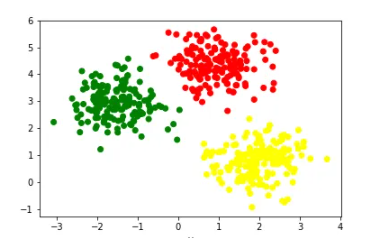

[Photo Reference](https://cmdlinetips.com/2019/05/k-means-clustering-in-python/)



So how is the optimal k selected? Currently there are two popular methods that helps in choosing the optimal value for k. The first one is the elbow method. The idea is to calculate the Within-Cluster-Sum of Squared Errors (WCSS) for different values of k, and choose the k for which WCSS starts to diminish. In the plot of WSS-versus-k, this is visible as an elbow. This can be easily implemented in python using the sklearn library.

The silhouette method is another method that can be combined with the elbow method for validation of the clustering. The idea is that the silhouette value measures how similar a point is to its own cluster compared to the other clusters. A high value is desirable and indicates that the point is placed in the correct cluster. This can also be easily implemented in python by plotting a graph of silhouette score vs k.

Elbow method and silhouette method are not alternatives rather they are used together to find the optimal value of k confidently.

I've specifically chosen this wine data, because of its attributes. K-Means Clustering only works for purely numerical data. If we use Kmeans + one hot encoding it will increase the size of the dataset extensively if the categorical attributes have a large number of categories. This will make the Kmeans computationally costly. Also, the cluster means will make no sense since the 0 and 1 are not the real values of the data. 

For this notebook, what I'll try to do is to drop the customer segment column, and cluster the remaining data.

Now, let's get started!

## Data Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans
import warnings
import os
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

### Import the Data

In [ ]:
df = pd.read_csv('../input/wine-customer-segmentation/Wine.csv',sep = ",", header = 0)

##### Take a peek at the Dataset

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.info()

##### Drop the Customer_Segment

In [ ]:
df.drop('Customer_Segment', axis = 1, inplace = True)

In [ ]:
df.describe()

### Check for Missing Values

In [ ]:
df.info()
sns.set_palette("GnBu_d")
plt.title("Missingess Map")
plt.rcParams['figure.figsize'] = (8.0, 5.0)
sns.heatmap(df.isnull(), cbar=False)

##### There are no missing values

### Data Exploration

##### Pairplots

In [ ]:
sns.set_palette("GnBu_d")
sns.pairplot(df)

##### Let's see if there are features that are highly correlated

In [ ]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.title("Correlation Plot")
sns.heatmap(df.corr())

##### Looks like Total_Phenlos and Flavanoids are correlated. We'll try to drop one of them to avoid multicollinearity issue in our clustering model

##### Let's confirm by looking at the Variance Inflation Factor

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
df_numeric = add_constant(df)
VIF_frame = pd.Series([variance_inflation_factor(df_numeric.values, i) 
               for i in range(df_numeric.shape[1])], 
              index=df_numeric.columns).to_frame()

VIF_frame.drop('const', axis = 0, inplace = True) 
VIF_frame.rename(columns={VIF_frame.columns[0]: 'VIF'},inplace = True)
VIF_frame[~VIF_frame.isin([np.nan, np.inf, -np.inf]).any(1)]

##### Flavanoids has a high VIF, we should definitely drop it.

In [ ]:
df.drop('Flavanoids', axis = 1, inplace = True)

### Feature Scaling

##### It's never bad to scale features

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_copy = df.copy()
df_copy = pd.DataFrame(scaler.fit_transform(df), 
                                      index=df.index,
                                      columns=df.columns)
df_copy

## K-Means Clustering Implementation

### Clusters Initialization and Finding k.
##### Using all the features:

In [ ]:
X1 = df_copy.iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state = 823, algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('WCSS')
plt.title('Elbow Method Diagram')
plt.show()

##### We get the intuition that the best number of clusters is 3 because the Within-Cluster-Sum of Squared Errors (WCSS) starts to diminish at k = 3.

In [ ]:
algorithm = (KMeans(n_clusters = 3 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 823, algorithm='elkan') )
algorithm.fit(X1)
labels = algorithm.labels_
centroids = algorithm.cluster_centers_
centroids

##### Inserting the cluster labels to the dataframe

In [ ]:
df['Cluster'] = labels
df_copy['Cluster'] = labels
df.head()

##### Now let's see which features are important to the clustering we just did. Let's utilize the RandomForest Feature Importance Plot

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 823)
df_dv = df.copy()
df_dv.drop('Cluster', axis = 1, inplace = True)
rfc.fit(df_dv,df['Cluster'])
features = df_dv.columns.tolist()
feature_value = rfc.feature_importances_
d = {'Features' : features, 'Values' : feature_value}
fi = pd.DataFrame(d).sort_values('Values', ascending = False).reset_index()
fi
plt.rcParams['figure.figsize'] = (20.0, 5.0)
ax = sns.barplot(x=fi['Features'], y = fi['Values'], data = fi, palette="Blues_d")

##### Now let's try to visualize the segmentation

##### Pairplots using the top 6 important features for the clusters

In [ ]:
sns.pairplot(df[['Proline','OD280','Color_Intensity','Alcohol','Hue','Total_Phenols','Cluster']],palette = 'colorblind',hue='Cluster');

##### Some zoomed in biplots

In [ ]:
fig, axs = plt.subplots(ncols=3,nrows=3, figsize = (15,15))
sns.scatterplot(x="Alcohol", y="Proline", hue="Cluster",
                     palette = 'colorblind', data = df, legend = False, s = 200, ax=axs[0][0])
sns.scatterplot(x="Ash", y="Proline", hue="Cluster",
                     palette = 'colorblind', data = df, legend = False, s = 200, ax=axs[0][1])
sns.scatterplot(x="Magnesium", y="Proanthocyanins", hue="Cluster",
                     palette = 'colorblind', data = df, legend = False, s = 200,  ax=axs[0][2])
sns.scatterplot(x="Proanthocyanins", y="Color_Intensity", hue="Cluster",
                     palette = 'colorblind', data = df, legend = False, s = 200,  ax=axs[1][0])
sns.scatterplot(x="Proline", y="OD280", hue="Cluster",
                     palette = 'colorblind', data = df, legend = False, s = 200,  ax=axs[1][1])
sns.scatterplot(x="Nonflavanoid_Phenols", y="Proline", hue="Cluster",
                     palette = 'colorblind', data = df, legend = False, s = 200, ax=axs[1][2])
sns.scatterplot(x="Color_Intensity", y="Hue", hue="Cluster",
                     palette = 'colorblind', data = df, legend = False, s = 200,  ax=axs[2][0])
sns.scatterplot(x="Color_Intensity", y="Proline", hue="Cluster",
                     palette = 'colorblind', data = df, legend = False, s = 200,  ax=axs[2][1])
sns.scatterplot(x="Ash_Alcanity", y="Proline", hue="Cluster",
                     palette = 'colorblind', data = df, legend = False, s = 200, ax=axs[2][2])

##### Box Plots and Violin Plots

In [ ]:
fig, axs = plt.subplots(ncols=4,nrows=2, figsize = (20,10))
sns.boxplot(x="Cluster", y="Proline", palette = 'colorblind', data = df, ax=axs[0][0])
sns.stripplot(x='Cluster',y='Proline', palette = 'colorblind', data=df, jitter=True, ax=axs[0][0])

sns.boxplot(x="Cluster", y="Color_Intensity", palette = 'colorblind', data = df, ax=axs[0][1])
sns.stripplot(x='Cluster',y='Color_Intensity', palette = 'colorblind', data=df, jitter=True, ax=axs[0][1])

sns.boxplot(x="Cluster", y="OD280", palette = 'colorblind', data = df, ax=axs[0][2])
sns.stripplot(x='Cluster',y='OD280', palette = 'colorblind', data=df, jitter=True, ax=axs[0][2])

sns.boxplot(x="Cluster", y="Alcohol", palette = 'colorblind', data = df, ax=axs[0][3])
sns.stripplot(x='Cluster',y='Alcohol', palette = 'colorblind', data=df, jitter=True, ax=axs[0][3])

sns.violinplot(x="Cluster", y="Hue", palette = 'colorblind', data = df, ax=axs[1][0])
sns.violinplot(x="Cluster", y="Total_Phenols", palette = 'colorblind', data = df, ax=axs[1][1])
sns.violinplot(x="Cluster", y="Malic_Acid", palette = 'colorblind', data = df, ax=axs[1][2])
sns.violinplot(x="Cluster", y="Ash_Alcanity", palette = 'colorblind', data = df, ax=axs[1][3])

##### Parallel Coordinates from pandas.plotting

In [ ]:
from pandas.plotting import parallel_coordinates
parallel_coordinates(df_copy[['Proline','OD280','Alcohol','Color_Intensity','Total_Phenols','Cluster']], "Cluster",  colormap = 'Accent')
plt.ioff()

In [ ]:
df_grouped = df_copy.groupby('Cluster',as_index=False).mean()
df_grouped = df_grouped[['Proline','OD280','Alcohol','Color_Intensity','Total_Phenols','Hue','Cluster']]
df_grouped

##### Radar Chart

In [ ]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
categories = ['Proline','OD280','Alcohol','Color_Intensity','Hue','Total_Phenols']
N = len(categories)
 
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
ax = plt.subplot(111, polar=True)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
plt.xticks(angles[:-1], categories)
 
ax.set_rlabel_position(0)
plt.yticks([-2,-1,0,1,2], ["-2","0","1","2"], color="grey", size=7)
plt.ylim(-1.8,1.8)

values=df_grouped.loc[0].drop('Cluster').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Cluster 0")
ax.fill(angles, values, 'b', alpha=0.2, color = "#3475B9")
 
values=df_grouped.loc[1].drop('Cluster').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Cluster 1")
ax.fill(angles, values, 'r', alpha=0.5, color = "#BAAC43")

values=df_grouped.loc[2].drop('Cluster').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Cluster 1")
ax.fill(angles, values, 'r', alpha=0.2, color = "#4EA976")
 
# Add legend
plt.rcParams['figure.figsize'] = (10.0, 10.0)

##### 3D Plots

In [ ]:
data = go.Scatter3d(
    x= df['Proline'],
    y= df['OD280'],
    z= df['Alcohol'],
    mode='markers',
     marker=dict(
        color= df['Cluster'],
        size= 18,
        opacity=0.8,
        colorscale = 'Geyser'
     )
)
data = [data]
layout = go.Layout(
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Proline'),
            yaxis = dict(title  = 'OD280'),
            zaxis = dict(title  = 'Alcohol')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [ ]:
data = go.Scatter3d(
    x= df['OD280'],
    y= df['Color_Intensity'],
    z= df['Alcohol'],
    mode='markers',
     marker=dict(
        color= df['Cluster'],
        size= 18,
        opacity=0.8,
        colorscale = 'Geyser'
     )
)
data = [data]
layout = go.Layout(
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'OD280'),
            yaxis = dict(title  = 'Color_Intensity'),
            zaxis = dict(title  = 'Alcohol')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

##### That's it! Hope you learned something from this notebook

##### References:
* [StatquestVid](https://www.youtube.com/watch?v=4b5d3muPQmA)
* [Plotly 3D Plots](https://plotly.com/python/3d-scatter-plots/)

Please note that all that I've written here is based on my own interpretation and does not represent the view/s of the instructor/s or author/s from the above reference/s